In [21]:
import numpy as np
import os
from imageio import imread
from skimage.transform import resize
import datetime
import os
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

We set the random seed so that the results don't vary drastically.

In [23]:
import numpy as np
import os
#from scipy.misc.pilutil import imread, imresize
import datetime
import os
from PIL import Image, ImageFilter, ImageEnhance
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [24]:
np.random.seed(30)
import random as rn
rn.seed(30)
from tensorflow import keras
import tensorflow as tf
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

data path: /home/datasets/Project_data

In [25]:
# train and validatiaon data creator with ablation
# when ablation is 10, then 10 folders for each label will be selected.
def get_data(path, ablation=None):
    train_doc = np.random.permutation(open(path+'train.csv').readlines())
    val_doc = np.random.permutation(open(path+'val.csv').readlines())
    counts = np.zeros(5) # count for loading folders for 5 classes
    train_data = []
    val_data = []
    # when ablation is None pass full training and val data
    if ablation is not None:
        # iterating train doc
        for doc in train_doc:
            label = int(doc.strip().split(';')[2])
            if counts[label] < ablation:
                train_data.append(doc)
                counts[label] += 1 
        counts = np.zeros(5)
        # iterating val doc
        for doc in val_doc:
            label = int(doc.strip().split(';')[2])
            if counts[label] < ablation:
                val_data.append(doc)
                counts[label] += 1
    else:
        train_data, val_data = train_doc, val_doc
    return train_data, val_data

In [26]:
train_doc = np.random.permutation(open('/home/datasets/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/home/datasets/Project_data/val.csv').readlines())
batch_size = 32 # experiment with the batch size
enable_augmentation = False # augmentation of Data
# sequence ids
# selecting alternate frames from 8 to 27.
seq_idx = range(8,27,2)
# image dimensions
dim_x, dim_y = 100, 100

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [27]:
# generator with augmentation for train data
def generator(source_path, folder_list, batch_size, is_train = False, augmention = False, debug=False):
    # print('\nSource path = ', source_path, '; batch size =', batch_size)
    img_idx = seq_idx #create a list of image numbers you want to use for a particular video
    x = len(img_idx)
    y, z = dim_x, dim_y
    while True:
        # doubling the data for augmentation
        if is_train and augmention:
            t = np.concatenate((np.random.permutation(folder_list), np.random.permutation(folder_list)))
        else:
            t = np.random.permutation(folder_list)
            
        if (len(t)%batch_size) == 0:
            num_batches = int(len(t)/batch_size)
        else:
            num_batches = len(t)//batch_size + 1
            
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                if debug:
                    plt.figure(figsize=(20,5))
                #handling remaining datapoints
                folder_idx = folder + (batch*batch_size)
                if folder_idx >= len(t):
                    break
                folder_str = t[folder_idx]
                imgs = os.listdir(source_path+'/'+ folder_str.split(';')[0]) # read all the images in the folder
                # randomly enabling augmentation and augmentation type
                aug_type = None
                if is_train and augmention and rn.randint(0,1) == 1:
                    aug_type = rn.randint(0, 4) #randomly selecting augmentation type
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ folder_str.strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                    # plotting original images for debugging purpose only
                    if debug:
                        plt.subplot(2, x, idx+1)
                        plt.imshow(image.astype('uint8'))

                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    # making the rectangle images into square by cropping sides
                    # so the aspect ration can be mantained while resizing.
                    if image.shape[1] > image.shape[0]:
                        diff_px = image.shape[1] - image.shape[0]
                        crop_start = diff_px//2
                        crop_end = crop_start + image.shape[0]
                        image = image[:, crop_start:crop_end]
                    elif image.shape[0] > image.shape[1]:
                        diff_px = image.shape[0] - image.shape[1]
                        crop_start = diff_px//2
                        crop_end = crop_start + image.shape[1]
                        image = image[:, crop_start:crop_end]

                    resized_im = resize(image, (y,z))

                    if aug_type is not None:
                        if aug_type == 0: # edge Enhancement
                            resized_im = np.array(Image.fromarray(resized_im, 'RGB').filter(ImageFilter.EDGE_ENHANCE))
                        elif aug_type == 1: # adding gaussian blur
                            resized_im = np.array(Image.fromarray(resized_im, 'RGB').filter(ImageFilter.GaussianBlur(1)))
                        elif aug_type == 2: # enchancing image detailing
                            resized_im = np.array(Image.fromarray(resized_im, 'RGB').filter(ImageFilter.DETAIL))
                        elif aug_type == 3: # sharpening image
                            resized_im = np.array(Image.fromarray(resized_im, 'RGB').filter(ImageFilter.SHARPEN))
                        elif aug_type == 4: # Brightness enhancement
                            resized_im = np.array(ImageEnhance.Brightness((Image.fromarray(resized_im, 'RGB'))).enhance(1.5))
                    # plotting rezised images for debugging purpose only
                    if debug:
                        plt.subplot(2, x, idx+x+1)
                        plt.imshow(resized_im)

                    batch_data[folder,idx,:,:,0] = resized_im[:,:,0]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = resized_im[:,:,1]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = resized_im[:,:,2]/255 #normalise and feed in the image

                batch_labels[folder, int(folder_str.strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
                

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [28]:
curr_dt_time = datetime.datetime.now()

train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'

#multiply number train seq by 2 when using augmentation
multiplier = 1
if enable_augmentation:
    multiplier = 2
num_train_sequences = len(train_doc)*multiplier
print('# training sequences =', num_train_sequences)

num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)

num_epochs = 50 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 50


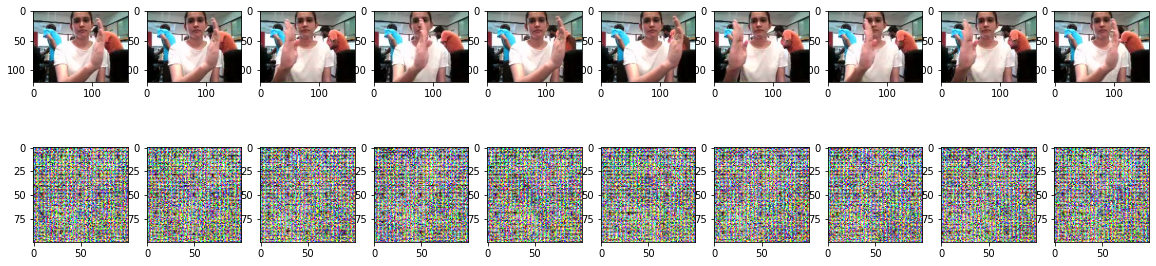

In [29]:
# testing generator
test_gen = generator(train_path, train_doc, 1, is_train = True, augmention = True, debug = True)
d = next(test_gen)[0]

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [31]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Dropout, Flatten, BatchNormalization, Activation, Conv3D, MaxPooling3D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Bidirectional, BatchNormalization, Activation, Dropout, GlobalAveragePooling2D, GlobalAveragePooling3D, ConvLSTM2D
from keras.layers.convolutional import Conv2D, Conv3D, MaxPooling2D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

#input shape for the st layer
input_shape = (len(seq_idx), dim_x, dim_y, 3)
np.random.seed(30)

#write your model here
#input shape for the st layer
input_shape = (len(seq_idx), dim_x, dim_y, 3)
np.random.seed(30)

### Experiment - 1 with **Conv3D**

In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, GlobalAveragePooling3D
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU

model = Sequential()

# First Conv Layer
model.add(Conv3D(32, kernel_size=(3,3,3), padding='same', input_shape=input_shape))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling3D(pool_size=(2,2,2)))

# Second Conv Layer
model.add(Conv3D(64, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling3D(pool_size=(2,2,2)))

# Global Average Pooling
model.add(GlobalAveragePooling3D())

# Fully Connected Layer
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))  # Dropout for regularization

# Output Layer
model.add(Dense(5, activation='softmax'))


2025-03-31 04:31:11.900338: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1052] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-03-31 04:31:11.932688: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1052] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-03-31 04:31:11.935804: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1052] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-03-31 04:31:11.942104: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1052] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-03-31 04:31:11.945187: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1052] successful NUMA node read f

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [34]:
optimiser = optimizers.Adam(lr=0.01) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 10, 100, 100, 32)  2624      
                                                                 
 batch_normalization (BatchN  (None, 10, 100, 100, 32)  128      
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 10, 100, 100, 32)  0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 5, 50, 50, 32)    0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 5, 50, 50, 64)     55360     
                                                                 
 batch_normalization_1 (Batc  (None, 5, 50, 50, 64)    2

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [35]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [36]:
import os
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from datetime import datetime

# Generate unique model name with timestamp
model_name = f"model_init_exp_16_{datetime.now().strftime('%Y%m%d_%H%M%S')}/"

# Create directory if it doesn't exist
os.makedirs(model_name, exist_ok=True)

# Define model checkpoint filepath
filepath = (f"{model_name}model-{{epoch:05d}}-{{loss:.5f}}-"
            f"{{categorical_accuracy:.5f}}-{{val_loss:.5f}}-"
            f"{{val_categorical_accuracy:.5f}}.h5")

# Model checkpoint callback
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_loss', verbose=1, 
                             save_best_only=False, save_weights_only=False, 
                             mode='auto', save_freq='epoch')

# Reduce learning rate callback
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, 
                       min_lr=1e-6, verbose=1, mode='min')

# List of callbacks
callbacks_list = [checkpoint, LR]


The `steps_per_epoch` and `validation_steps` are used by `fit` method to decide the number of next() calls it need to make.

In [37]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [40]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/50
21/21 [==============================] - ETA: 0s - loss: 1.0775 - categorical_accuracy: 0.5402
Epoch 00001: saving model to model_init_exp_16_20250331_043417/model-00001-1.07747-0.54018-0.76712-0.41406.h5
21/21 [==============================] - 31s 2s/step - loss: 1.0775 - categorical_accuracy: 0.5402 - val_loss: 0.7671 - val_categorical_accuracy: 0.4141 - lr: 3.2000e-06
Epoch 2/50
21/21 [==============================] - ETA: 0s - loss: 1.0784 - categorical_accuracy: 0.5253
Epoch 00002: saving model to model_init_exp_16_20250331_043417/model-00002-1.07837-0.52530-0.75782-0.47656.h5
21/21 [==============================] - 31s 2s/step - loss: 1.0784 - categorical_accuracy: 0.5253 - val_loss: 0.7578 - val_categorical_accuracy: 0.4766 - lr: 3.2000e-06
Epoch 3/50
21/21 [==============================] - ETA: 0s - loss: 1.0552 - categorical_accuracy: 0.5223
Epoch 00003: saving model to model_init_exp_16_20250331_043417/model-00003-1.05523-0.52232-0.74757-0.46875.h5
21/21 [=====

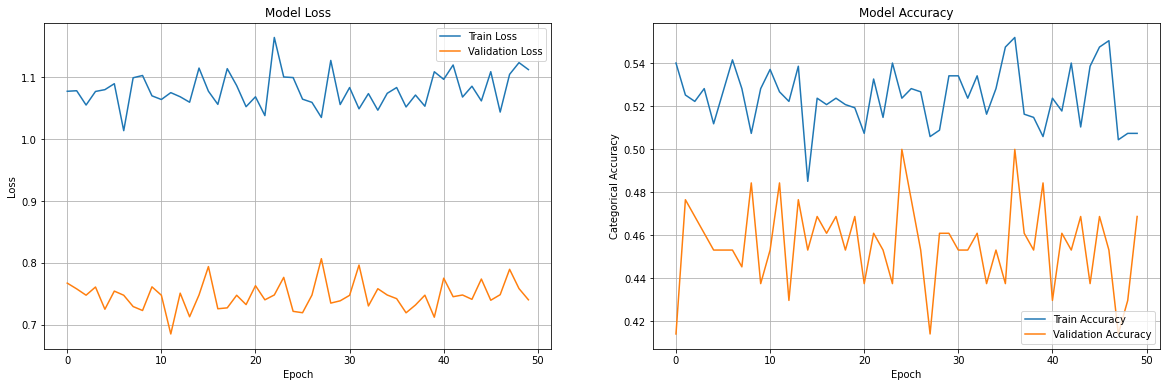

In [41]:
import matplotlib.pyplot as plt

# Create a figure with two subplots (1 row, 2 columns)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

# Plot training & validation loss
ax1.plot(history.history['loss'], label='Train Loss')
ax1.plot(history.history['val_loss'], label='Validation Loss')
ax1.set_title('Model Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend(loc='upper right')
ax1.grid(True)

# Plot training & validation accuracy
ax2.plot(history.history['categorical_accuracy'], label='Train Accuracy')
ax2.plot(history.history['val_categorical_accuracy'], label='Validation Accuracy')
ax2.set_title('Model Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Categorical Accuracy')
ax2.legend(loc='lower right')
ax2.grid(True)

# Show the plot
plt.show()


### Experiment - 2 with **TimeDistributed Conv2D + GRU**

In [42]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GRU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Initialize Sequential Model
model = Sequential()

# 1st Convolutional Block
model.add(TimeDistributed(Conv2D(32, (3,3), activation='relu', padding='same', kernel_initializer='he_normal'), 
                          input_shape=input_shape))
model.add(TimeDistributed(MaxPooling2D((2,2))))
model.add(BatchNormalization())
model.add(Dropout(0.2))

# 2nd Convolutional Block
model.add(TimeDistributed(Conv2D(64, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')))
model.add(TimeDistributed(MaxPooling2D((2,2))))
model.add(BatchNormalization())
model.add(Dropout(0.3))  # Increased dropout

# Feature Extraction
model.add(TimeDistributed(GlobalAveragePooling2D()))
model.add(TimeDistributed(Dense(32, activation='relu', kernel_initializer='he_normal')))
model.add(BatchNormalization())
model.add(Dropout(0.3))  # Increased dropout for better regularization

# GRU for Sequential Learning
model.add(GRU(128, return_sequences=False))  
model.add(BatchNormalization())
model.add(Dropout(0.4))  # Higher dropout in GRU layer

# Output Layer
model.add(Dense(5, activation='softmax'))

# Optimizer with improved learning rate
optimizer = Adam(learning_rate=0.001)  

# Compile Model
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Learning Rate Reduction Callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6, verbose=1)

# Model Summary
print(model.summary())


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 10, 100, 100, 32)  896      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 10, 50, 50, 32)   0         
 tributed)                                                       
                                                                 
 batch_normalization_2 (Batc  (None, 10, 50, 50, 32)   128       
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 10, 50, 50, 32)    0         
                                                                 
 time_distributed_2 (TimeDis  (None, 10, 50, 50, 64)   18496     
 tributed)                                            

In [43]:
train_generator = generator(train_path, train_doc, batch_size, is_train = True, augmention = enable_augmentation)
val_generator = generator(val_path, val_doc, batch_size)

In [44]:
import os
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from datetime import datetime

# Generate unique model name with timestamp
model_name = f"model_init_exp_16_{datetime.now().strftime('%Y%m%d_%H%M%S')}/"

# Create directory if it doesn't exist
os.makedirs(model_name, exist_ok=True)

# Define model checkpoint filepath
filepath = (f"{model_name}model-{{epoch:05d}}-{{loss:.5f}}-"
            f"{{categorical_accuracy:.5f}}-{{val_loss:.5f}}-"
            f"{{val_categorical_accuracy:.5f}}.h5")

# Model checkpoint callback
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_loss', verbose=1, 
                             save_best_only=False, save_weights_only=False, 
                             mode='auto', save_freq='epoch')

# Reduce learning rate callback
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, 
                       min_lr=1e-6, verbose=1, mode='min')

# List of callbacks
callbacks_list = [checkpoint, LR]


In [45]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [46]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/50
21/21 [==============================] - ETA: 0s - loss: 1.8212 - categorical_accuracy: 0.3482
Epoch 00001: saving model to model_init_exp_16_20250331_054224/model-00001-1.82120-0.34821-1.26270-0.17969.h5
21/21 [==============================] - 32s 2s/step - loss: 1.8212 - categorical_accuracy: 0.3482 - val_loss: 1.2627 - val_categorical_accuracy: 0.1797 - lr: 0.0010
Epoch 2/50
21/21 [==============================] - ETA: 0s - loss: 1.5340 - categorical_accuracy: 0.3795
Epoch 00002: saving model to model_init_exp_16_20250331_054224/model-00002-1.53398-0.37946-1.28093-0.13281.h5
21/21 [==============================] - 30s 2s/step - loss: 1.5340 - categorical_accuracy: 0.3795 - val_loss: 1.2809 - val_categorical_accuracy: 0.1328 - lr: 0.0010
Epoch 3/50
21/21 [==============================] - ETA: 0s - loss: 1.3328 - categorical_accuracy: 0.4673
Epoch 00003: saving model to model_init_exp_16_20250331_054224/model-00003-1.33278-0.46726-1.23227-0.14844.h5
21/21 [=============

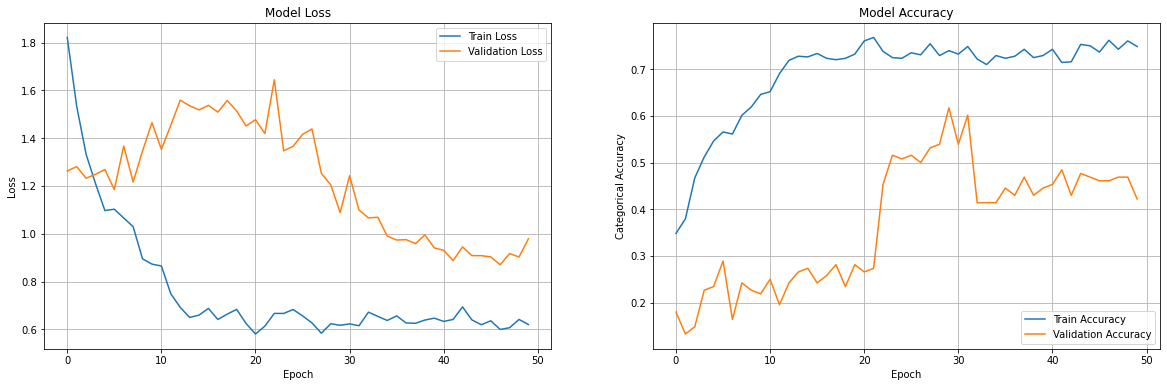

In [47]:
import matplotlib.pyplot as plt

# Create a figure with two subplots (1 row, 2 columns)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

# Plot training & validation loss
ax1.plot(history.history['loss'], label='Train Loss')
ax1.plot(history.history['val_loss'], label='Validation Loss')
ax1.set_title('Model Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend(loc='upper right')
ax1.grid(True)

# Plot training & validation accuracy
ax2.plot(history.history['categorical_accuracy'], label='Train Accuracy')
ax2.plot(history.history['val_categorical_accuracy'], label='Validation Accuracy')
ax2.set_title('Model Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Categorical Accuracy')
ax2.legend(loc='lower right')
ax2.grid(True)

# Show the plot
plt.show()


### Experiment - 3 with **TimeDistributed + Conv2D + LSTM**

In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Initialize Model
model = Sequential()

# 1st Convolutional Block
model.add(TimeDistributed(Conv2D(32, (3,3), padding='same', kernel_initializer='he_normal'), input_shape=input_shape))
model.add(BatchNormalization())  # BatchNorm Before Activation
model.add(TimeDistributed(LeakyReLU(alpha=0.1)))
model.add(TimeDistributed(MaxPooling2D((2,2))))
model.add(Dropout(0.1))  # Lower dropout to retain features

# 2nd Convolutional Block
model.add(TimeDistributed(Conv2D(64, (3,3), padding='same', kernel_initializer='he_normal')))
model.add(BatchNormalization())
model.add(TimeDistributed(LeakyReLU(alpha=0.1)))
model.add(TimeDistributed(MaxPooling2D((2,2))))
model.add(Dropout(0.3))

# 3rd Convolutional Block
model.add(TimeDistributed(Conv2D(128, (3,3), padding='same', kernel_initializer='he_normal')))
model.add(BatchNormalization())
model.add(TimeDistributed(LeakyReLU(alpha=0.1)))
model.add(TimeDistributed(MaxPooling2D((2,2))))
model.add(Dropout(0.4))  # Higher dropout for regularization

# Feature Extraction with GlobalAveragePooling2D
model.add(TimeDistributed(GlobalAveragePooling2D()))

# LSTM for Sequential Processing
model.add(LSTM(64, return_sequences=False))  # Adjust LSTM size based on complexity
model.add(BatchNormalization())
model.add(Dropout(0.4))

# Output Layer
model.add(Dense(5, activation='softmax'))

# Optimizer
optimizer = Adam(learning_rate=0.001)

# Compile Model
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Learning Rate Reduction Callback with `min_delta`
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_delta=1e-4, min_lr=1e-6, verbose=1)

# Model Summary
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 10, 100, 100, 32)  896      
 ibuted)                                                         
                                                                 
 batch_normalization (BatchN  (None, 10, 100, 100, 32)  128      
 ormalization)                                                   
                                                                 
 time_distributed_1 (TimeDis  (None, 10, 100, 100, 32)  0        
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 10, 50, 50, 32)   0         
 tributed)                                                       
                                                                 
 dropout (Dropout)           (None, 10, 50, 50, 32)   

In [34]:
train_generator = generator(train_path, train_doc, batch_size, is_train = True, augmention = enable_augmentation)
val_generator = generator(val_path, val_doc, batch_size)

In [35]:
import os
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from datetime import datetime

# Generate unique model name with timestamp
model_name = f"model_init_exp_3_{datetime.now().strftime('%Y%m%d_%H%M%S')}/"

# Create directory if it doesn't exist
os.makedirs(model_name, exist_ok=True)

# Define model checkpoint filepath
filepath = (f"{model_name}model-{{epoch:05d}}-{{loss:.5f}}-"
            f"{{categorical_accuracy:.5f}}-{{val_loss:.5f}}-"
            f"{{val_categorical_accuracy:.5f}}.h5")

# Model checkpoint callback
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_loss', verbose=1, 
                             save_best_only=False, save_weights_only=False, 
                             mode='auto', save_freq='epoch')

# Reduce learning rate callback
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, 
                       min_lr=1e-6, verbose=1, mode='min')

# List of callbacks
callbacks_list = [checkpoint, LR]


In [36]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [37]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/50


2025-03-31 07:44:31.270828: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302
2025-03-31 07:44:32.810964: I tensorflow/stream_executor/cuda/cuda_blas.cc:1792] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


21/21 [==============================] - ETA: 0s - loss: 1.6079 - categorical_accuracy: 0.3958
Epoch 00001: saving model to model_init_exp_3_20250331_074414/model-00001-1.60794-0.39583-1.35316-0.14062.h5
21/21 [==============================] - 39s 2s/step - loss: 1.6079 - categorical_accuracy: 0.3958 - val_loss: 1.3532 - val_categorical_accuracy: 0.1406 - lr: 0.0010
Epoch 2/50
21/21 [==============================] - ETA: 0s - loss: 1.3227 - categorical_accuracy: 0.4881
Epoch 00002: saving model to model_init_exp_3_20250331_074414/model-00002-1.32275-0.48810-1.35220-0.14062.h5
21/21 [==============================] - 27s 1s/step - loss: 1.3227 - categorical_accuracy: 0.4881 - val_loss: 1.3522 - val_categorical_accuracy: 0.1406 - lr: 0.0010
Epoch 3/50
21/21 [==============================] - ETA: 0s - loss: 1.2055 - categorical_accuracy: 0.4970
Epoch 00003: saving model to model_init_exp_3_20250331_074414/model-00003-1.20553-0.49702-1.31075-0.12500.h5
21/21 [===========================

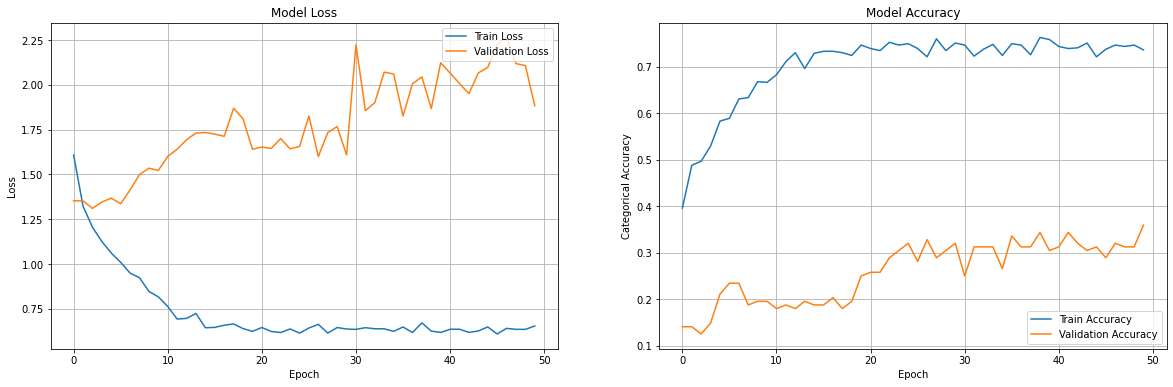

In [38]:
import matplotlib.pyplot as plt

# Create a figure with two subplots (1 row, 2 columns)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

# Plot training & validation loss
ax1.plot(history.history['loss'], label='Train Loss')
ax1.plot(history.history['val_loss'], label='Validation Loss')
ax1.set_title('Model Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend(loc='upper right')
ax1.grid(True)

# Plot training & validation accuracy
ax2.plot(history.history['categorical_accuracy'], label='Train Accuracy')
ax2.plot(history.history['val_categorical_accuracy'], label='Validation Accuracy')
ax2.set_title('Model Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Categorical Accuracy')
ax2.legend(loc='lower right')
ax2.grid(True)

# Show the plot
plt.show()
